In [78]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import sys
if not '..' in sys.path:
    sys.path.append('..')
from src.PPP import *
from src.utils import *

from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, make_scorer

#### Globals

In [2]:
PATH_RAW = '../data/raw_data/'
PATH_INTER = '../data/intermediate/'
PATH_DATA = '../data/data/'
PATH_MODELS = '../../models/'
PATH_IMAGES = '../assets/images/'

METHOD = 'multiclass'
TO_BIN = False

## Load trianing data

In [34]:
# CRC
train = pd.read_csv(PATH_DATA + "CRC_3200_train.csv")
#val = pd.read_csv(PATH_DATA + "CRC_320_val.csv", index_col=0)

# X, y (multiclass) and y (binary) for TRAINING
X_train, y_train, y_bin_train = train.drop(['tag', 'bin_tag', 'lemmas'], axis=1), train['tag'].copy(), train['bin_tag'].copy()
# X, y (multiclass) and y (binary) for VALIDATING
#X_val, y_val, y_bin_val = val.drop(['tag', 'bin_tag'], axis=1), val['tag'].copy(), val['bin_tag'].copy()

## Load test data

In [44]:
# CRC
test_CRC = pd.read_csv(PATH_DATA + "CRC_800_test.csv")

# X, y (multiclass) and y (binary)
X_test_CRC, y_test_CRC, y_bin_test_CRC = test_CRC.drop(['tag', 'bin_tag', 'lemmas'], axis=1), test_CRC['tag'].copy(), test_CRC['bin_tag'].copy()


In [10]:
# C3 (extended version of SOCC)
test_c3 = pd.read_csv(PATH_DATA + "C3_12000.csv")

# X, y
X_test_c3, y_bin_test_c3 = test_c3.drop(['bin_tag'], axis=1), test_c3['bin_tag'].copy()

In [14]:
# YNACC
test_ynacc = pd.read_csv(PATH_INTER + "ydata-ynacc-v1_0_expert_annotations.tsv", sep='\t')

_, test_ynacc = file_split(test_ynacc, test_size=0.2, text_column='text', tag_column='constructiveclass', out_dir=None)

test_ynacc['constructiveclass'] = test_ynacc.loc[:, 'constructiveclass'].map({'Constructive': '1',
                                                                      'Not constructive': '0'})

test_ynacc = preprocess_test(test_ynacc, text_column='text', tag_column='constructiveclass', pattern=None)
test_ynacc = test_ynacc.rename(columns={'text': 'text_review', 'constructiveclass': 'bin_tag'})

test_ynacc.to_csv(PATH_DATA + 'YNACC.csv', index=False)

# X, y
X_test_ynacc, y_bin_test_ynacc = test_ynacc.drop(['bin_tag'], axis=1), test_ynacc['bin_tag'].copy()

Splitting files...
Splitting finished.
Preprocessing of the test data...
Preprocessing finished in 445.30675888061523 seconds.


In [45]:
# Lists of data sets for testing
multiclass_X = [X_test_CRC]
multiclass_y = [y_test_CRC]

binary_X = [X_test_CRC, X_test_c3, X_test_ynacc]
binary_y = [y_bin_test_CRC, y_bin_test_c3, y_bin_test_ynacc]

Creating a DataFrame for each set of features in CRC

In [96]:
import warnings 
from sklearn.exceptions import ConvergenceWarning

# Filter out warnings from models
warnings.filterwarnings('ignore', category = ConvergenceWarning)
warnings.filterwarnings('ignore', category = DeprecationWarning)
warnings.filterwarnings('ignore', category = UserWarning)

# Dataframe to hold results
model_results = pd.DataFrame(columns = ['model', 'cv_mean', 'cv_std', 'test_result'])

# Custom scorer for cross validation
scorer = make_scorer(f1_score, greater_is_better=True, average='weighted')

def cv_model(train, train_labels, test, test_labels, model, name, model_results=None):
    """Perform 10 fold cross validation of a model"""
    
    cv_scores = cross_val_score(model, train, train_labels, cv=10, scoring=scorer, n_jobs=-1)
    
    test_res = f1_score(test_labels, model.predict(test), average='weighted')
    
    if model_results is not None:
        model_results = model_results.append(pd.DataFrame({'model': name, 
                                                           'cv_mean': cv_scores.mean(), 
                                                           'cv_std': cv_scores.std(),
                                                           'test_results': test_res},
                                                           index = [0]),
                                             ignore_index = True)

        return model_results


In [97]:
# All features

X_train = train.drop(['tag', 'bin_tag', 'lemmas'], axis=1)
X_test_CRC = test_CRC.drop(['tag', 'bin_tag', 'lemmas'], axis=1)

trans_all = ColumnTransformer(transformers=[
            ('review', TfidfVectorizer(min_df=1, max_df=0.1, encoding='utf-8', ngram_range=(1,1)), 'text_review'),
            ('pos', TfidfVectorizer(encoding='utf-8', ngram_range=(1,1)), 'text_pos'),
            ],
                         remainder='passthrough')

In [98]:
# pipeline: fit and transform data -> fit the classifier
pipeline = Pipeline([
                       ('union', trans),
])

X_train_new = pipeline.fit_transform(X_train)
X_test_CRC_new = pipeline.transform(X_test_CRC)

clf = GradientBoostingClassifier(n_estimators=300,
                                  learning_rate=0.03,
                                  max_depth=8,
                                  validation_fraction=0.1,
                                  n_iter_no_change=5, tol=0.005,
                                  random_state=0,
                                  verbose=1)

# Fit the model on new set of features and record results of CV and test
model_results = cv_model(X_train_new, y_train, X_test_CRC_new, y_test_CRC, clf, 'all', model_results)

NotFittedError: This GradientBoostingClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
model_results.head()

In [ ]:
# Lexical features

X_train = train['text_review'].copy()
X_test_CRC = test_CRC['text_review'].copy()

trans_lexical = ColumnTransformer(transformers=[
            ('review', TfidfVectorizer(min_df=1, max_df=0.1, encoding='utf-8', ngram_range=(1,1)), 'text_review'),
            ],
                         remainder='drop')

In [ ]:
# Syntactic features

X_train = train['text_pos'].copy()
X_test_CRC = test_CRC['text_pos'].copy()
            
trans_syntactic = ColumnTransformer(transformers=[
            ('pos', TfidfVectorizer(encoding='utf-8', ngram_range=(1,1)), 'text_pos'),
            ],
                         remainder='drop')

In [ ]:
# Discourse features

X_train = train[['num_discourse', 'num_modals']].copy()
X_test_CRC = test_CRC[['num_discourse', 'num_modals']].copy()



In [ ]:
# Text quality features

X_train = train[['read_score', 'num_upper', 'num_unk', 'num_punct']].copy()
X_test_CRC = test_CRC[['read_score', 'num_upper', 'num_unk', 'num_punct']].copy()


In [ ]:
#


## Model training

We list the features to use in the Pipeline

In [35]:
numeric_features = list(X_train[['read_score', 'sentiment', 'num_tokens',
                                 'num_char', 'num_upper', 'named_entities',
                                 'num_positives', 'num_negatives', 'num_unk',
                                 'num_punct', 'num_discourse', 'num_modals',
                                 'avg_word_length']])

text_features = list(X_train[['text_review', 'text_pos']])

Custom transformer to transform the data and create a feature space

In [57]:
trans = ColumnTransformer(transformers=[
            ('review', TfidfVectorizer(min_df=1, max_df=0.1, encoding='utf-8', ngram_range=(1,1)), 'text_review'),
            ('pos', TfidfVectorizer(encoding='utf-8', ngram_range=(1,1)), 'text_pos'),
            #('num_attr', StandardScaler(), numeric_features),
            ],
                         remainder='passthrough')

Pipeline to sequentially transform the data and fit an estimator

In [58]:
pipeline = Pipeline([
                       ('union', trans),
                       ('clf', GradientBoostingClassifier(n_estimators=50,
                                                          learning_rate=0.1,
                                                          max_depth=8,
                                                          validation_fraction=0.1,
                                                          n_iter_no_change=2, tol=0.005,
                                                          random_state=0,
                                                          verbose=1))
])

GridSearch with 5 fold cross-validation to find the best set of features

In [59]:
param_grid = [{
    'clf__learning_rate': [0.03],
    'clf__n_estimators': [100, 300, 600],
    'clf__max_depth': [8, 12],
}]

# Training with all possible configurations
model = GridSearchCV(pipeline,
                      param_grid=param_grid,
                      scoring='f1_weighted',
                      n_jobs=-1,
                      cv=5,
                      verbose=1)

Model fitting...

In [60]:
if METHOD.lower() == 'binary':
    model.fit(X_train, y_bin_train)
elif METHOD.lower() == 'multiclass':
    model.fit(X_train, y_train)
else:
    raise ValueError('You must choose \'binary\' or \'multiclas\'.')

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 11.1min finished


      Iter       Train Loss   Remaining Time 
         1        3533.5266            2.80m
         2        3396.8347            2.88m
         3        3273.8531            3.02m
         4        3161.0982            3.07m
         5        3057.9432            3.11m
         6        2962.7712            3.08m
         7        2873.8658            3.05m
         8        2791.6650            3.03m
         9        2714.9806            3.01m
        10        2642.1705            2.99m
        20        2097.1597            2.81m
        30        1715.3270            2.74m
        40        1440.2453            2.66m
        50        1250.7845            2.53m
        60        1111.9144            2.39m
        70        1007.9074            2.25m
        80         921.2939            2.14m
        90         849.9142            2.01m
       100         790.3963            1.89m


## Model validation

Output of best parameter set and best accuracy average score

In [63]:
print(model.best_score_)
print(model.best_params_)
print(model.cv_results_)

0.6606481281984424
{'clf__learning_rate': 0.03, 'clf__max_depth': 8, 'clf__n_estimators': 300}
{'mean_fit_time': array([72.39443469, 76.60018873, 79.89142523, 93.81867633, 99.22286172,
       83.45705671]), 'std_fit_time': array([ 7.01956643, 10.35281639, 12.53446058, 14.07806773, 14.64301035,
       19.92501116]), 'mean_score_time': array([0.1380188 , 0.19505177, 0.16414351, 0.14787798, 0.1510684 ,
       0.11856236]), 'std_score_time': array([0.01887986, 0.07391424, 0.04847908, 0.01467252, 0.01682128,
       0.03785832]), 'param_clf__learning_rate': masked_array(data=[0.03, 0.03, 0.03, 0.03, 0.03, 0.03],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_clf__max_depth': masked_array(data=[8, 8, 8, 12, 12, 12],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_clf__n_estimators': masked_array(data=[100, 300, 600, 100, 300, 600],
             mask=[F

In [41]:
def to_binary(prediction):
    return 0 if prediction == 0 or prediction == 1 else 1

In [65]:
if METHOD.lower() == 'binary':
    y_pred_val = model.predict(X_val)
    print("Accuracy:", accuracy_score(y_bin_val, y_pred_val))
    print("F1 Score:", f1_score(y_bin_val, y_pred_val, average='weighted'))
    print(classification_report(y_bin_val, y_pred_val))
elif METHOD.lower() == 'multiclass':
    y_pred_val = model.predict(X_val)
    if TO_BIN:
        y_pred_val = [to_binary(x) for x in y_pred_val]
        print("Accuracy:", accuracy_score(y_bin_val, y_pred_val))
        print("F1 Score:", f1_score(y_bin_val, y_pred_val, average='weighted'))
        print(classification_report(y_bin_val, y_pred_val))
    else:
        print("Accuracy:", accuracy_score(y_val, y_pred_val))
        print("F1 Score:", f1_score(y_val, y_pred_val, average='weighted'))
        print(classification_report(y_val, y_pred_val))
else:
    raise ValueError('You must choose \'binary\' or \'multiclas\'.')

Accuracy: 0.665625
F1 Score: 0.6649011698500912
              precision    recall  f1-score   support

           0       0.81      0.51      0.63        43
           1       0.69      0.72      0.70       112
           2       0.66      0.68      0.67       120
           3       0.56      0.62      0.59        45

    accuracy                           0.67       320
   macro avg       0.68      0.64      0.65       320
weighted avg       0.67      0.67      0.66       320



Saving model

In [66]:
pickle.dump(model, open(PATH_MODELS+'v0_4_GBC_fullfeatures_withoutval_multiclass.sav', 'wb'))

## Model testing (multiclass model)

Model 1
Accuracy: 0.695
F1 Score: 0.691851895987115
              precision    recall  f1-score   support

           0       0.70      0.47      0.56       108
           1       0.70      0.74      0.72       280
           2       0.67      0.74      0.70       300
           3       0.74      0.70      0.72       112

    accuracy                           0.69       800
   macro avg       0.70      0.66      0.68       800
weighted avg       0.70      0.69      0.69       800



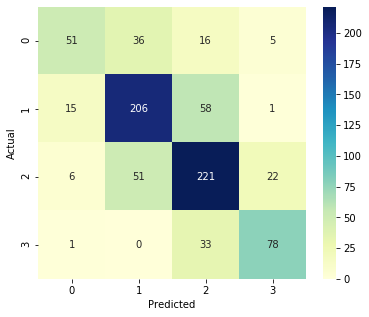

In [64]:
for i, (X, y) in enumerate(zip(multiclass_X, multiclass_y)):
    y_pred = model.predict(X) 
    print('Model {}'.format(i+1))
    print("Accuracy:", accuracy_score(y, y_pred))
    print("F1 Score:", f1_score(y, y_pred, average='weighted'))
    print(classification_report(y, y_pred))
    
    conf_mat = confusion_matrix(y, y_pred)
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(conf_mat, cmap="YlGnBu", annot=True, fmt='d')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    print("="*53)

## Model testing (binary model)

Model 1
Accuracy: 0.9433333333333334
F1 Score: 0.9433938452769391
              precision    recall  f1-score   support

         0.0       0.92      0.95      0.94      1097
         1.0       0.96      0.93      0.95      1303

    accuracy                           0.94      2400
   macro avg       0.94      0.94      0.94      2400
weighted avg       0.94      0.94      0.94      2400



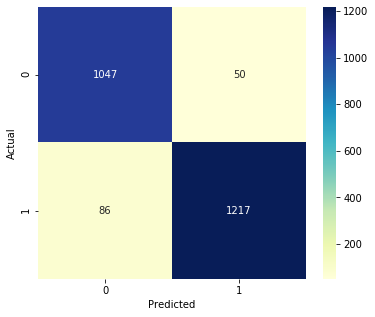

In [26]:
for i, (X, y) in enumerate(zip(list_X_bin_test, list_y_bin_test)):
    y_pred = model.predict(X)
    if len(np.unique(y_pred)) == 4:
        y_pred = [to_binary(x) for x in y_pred]
    print('Model {}'.format(i+1))
    print("Accuracy:", accuracy_score(y, y_pred))
    print("F1 Score:", f1_score(y, y_pred, average='weighted'))
    print(classification_report(y, y_pred))
    
    conf_mat = confusion_matrix(y, y_pred)
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(conf_mat, cmap="YlGnBu", annot=True, fmt='d')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    print("="*53)